In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # normalize image to [-1,1]

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
lr = 1e-4

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=True, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=True, activation='tanh'))

    return model

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = 0.5*tf.math.reduce_mean(tf.square(real_output-1))
    fake_loss = 0.5*tf.math.reduce_mean(tf.square(fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
def generator_loss(fake_output):
    return 0.5*tf.math.reduce_mean(tf.square(fake_output-1))

In [10]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

In [12]:
checkpoint_dir = './training_checkpoints_LSGAN'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [13]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.uniform([num_examples_to_generate, noise_dim],minval=0,maxval=1)

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim],minval=0,maxval=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return disc_loss, gen_loss

In [15]:
def train(dataset, epochs):
    dlossmat = []
    glossmat = []
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            d_loss,g_loss = train_step(image_batch)
            dlossmat = np.append(dlossmat,[d_loss],axis=0)
            glossmat = np.append(glossmat,[g_loss],axis=0)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch + 1,seed)

        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)
    
    return dlossmat,glossmat

In [16]:
def generate_and_save_images(model, epoch, test_input):

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./LSGAN_pic/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

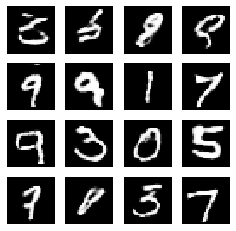

CPU times: user 25min 22s, sys: 1min 1s, total: 26min 23s
Wall time: 24min 10s


In [17]:
%%time
dlossmat,glossmat = train(train_dataset, EPOCHS)

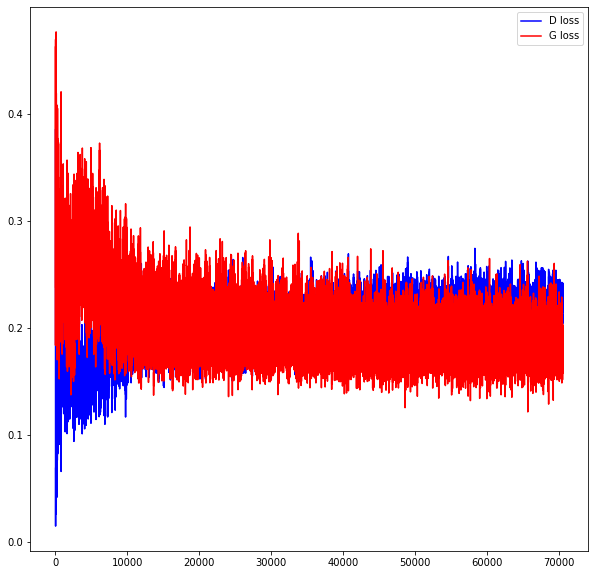

In [18]:
lossfig = plt.figure(figsize=(10,10))
axloss = lossfig.add_subplot(1,1,1)
axloss.plot(dlossmat[1:],'b')
axloss.plot(glossmat[1:],'r')
axloss.legend(['D loss', 'G loss'])

In [19]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [20]:
def display_image(epoch_no):
    return PIL.Image.open('./LSGAN_pic/image_at_epoch_{:04d}.png'.format(epoch_no))

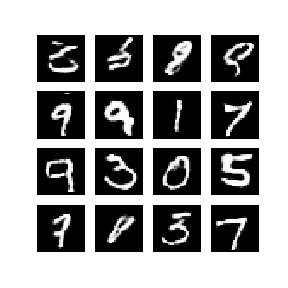

In [21]:
display_image(EPOCHS)

In [22]:
anim_file = 'LSGAN.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./LSGAN_pic/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

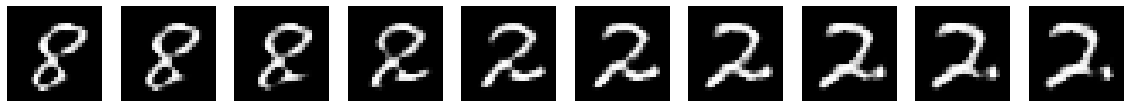

In [35]:
samp_num = 10
lat_for_interp1 = np.random.uniform(low=0,high=1,size=[1,noise_dim])
lat_for_interp2 = np.random.uniform(low=0,high=1,size=[1,noise_dim])

interp_tmp = np.linspace(0,1,num=samp_num)

for i in interp_tmp:
    L = (1-i)*lat_for_interp1 + i*lat_for_interp2
    if i==0:
        Latmat = L
    else:
        Latmat = np.append(Latmat,L,axis=0)
        
int_image = generator(Latmat,training=False)

intfig= plt.figure(figsize=(20,25))

for ipnum in range(samp_num):
    intsubp = intfig.add_subplot(1,samp_num,ipnum+1)
    intsubp.imshow(int_image[ipnum,:,:,0],cmap='gray')
    plt.axis('off')